In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import os
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from fastprogress.fastprogress import master_bar, progress_bar

/home/lulu/.pyenv/versions/3.9.7/envs/study_1_venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [19]:
# Put here all paths to directories.
# If we change the locations of files, we just have to change the paths here (as long as the name of the file remains the same).
dir_demographics = '../data/raw_data/demographics/Leiden/'
dir_water = '../data/raw_data/water/Leiden/'
dir_railway = '../data/raw_data/railway/'

In [15]:
zones = gpd.read_file(dir_demographics + 'PC_Leiden.gpkg', layer = 'zone')
demographics = pd.read_csv(dir_demographics + 'Leiden_exposure.csv')

# Preprocessing data
- Here we would like to merge the geometry of zones with demographic data.
- We first filter out the columns that we do not need in the two sets.
- Then we merge them.

In [16]:
# Filtering.
# First way: removing the columns that you do not want.
zones = zones.drop(columns = ['Postcode','gemeente','area_ratio'])
# Second way: selecting only the useful columns.
demographics = demographics.loc[:,['id_split','expos_NW','expos_NL','expos_WE',
                                   'pop_res','expos_NL_c','expos_WE_c','expos_NW_c']]

In [17]:
# Merging the two data sets.
zones = zones.merge(demographics, on = 'id_split')

<AxesSubplot:>

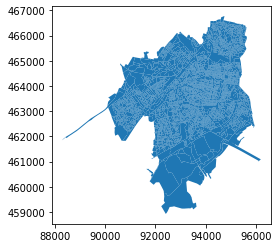

In [18]:
# We can display useful information.
zones.plot()

- Find regions clustering
- Label regions as segregated
- Tree classifier
- Creation of a dataset definining the boundaries
- Creation of a benchmark case
    - Compare accuracy with the tree classifier
    - Compare predicting power with the entropy

#### How much do you know:
- Pandas?
- Geopandas?
- Clustering and sk-learn?
- QGIS?

In [3]:
def cluster_analysis(zones,adjacency_matrix,exposure,dissimilarity_threshold):
    
   # N_component, labels = sparse.csgraph.connected_components(adjacency_matrix)
   # if N_component > 1:
   #     print(city + ' has a problem')
   zones = zones.copy()
   zones = zones.loc[:,['id_split','geometry']]
   zones = zones.merge(exposure, on = 'id_split', how = 'left')
   zones['expos_NW'] = zones['expos_NW'].mask(zones['expos_NW'].isna(),zones['expos_NW_c'].mean())
   zones['expos_rel'] = zones['expos_NW']/zones['expos_NW_c']
   zones['expos_rel'] = zones['expos_rel'].mask(zones['expos_NW_c']==0,0)
   X = np.array([zones.loc[:,'expos_NW']]).T
    
   clustering = AgglomerativeClustering(distance_threshold=dissimilarity_threshold,
                                        n_clusters=None,
                                        connectivity=adjacency_matrix,
                                        linkage = 'ward').fit(X)

   zones['region'] = clustering.labels_
   zones['weighted_expos'] = zones['expos_NW'] * zones['pop_res']
   zones['expos_std'] = np.sqrt(zones['expos_NW'].var())

   return zones

In [4]:
def std_conc_region(zones, cov_mat, reg_name):

    tot_pop_region = zones[['pop_res',reg_name]].groupby(by = reg_name).sum().reset_index()

    zones = zones.merge(tot_pop_region.rename(columns = {'pop_res':'pop_' + reg_name}), on = reg_name)
    # weight_pop corresponds to the theta in the technical report.
    zones['weight_pop'] = zones['pop_res'] / zones['pop_' + reg_name]

    weight_id_split = zones.set_index('id_split')['weight_pop'].copy()

    cov_mat = cov_mat.multiply(weight_id_split, axis = 0)
    cov_mat = cov_mat.multiply(weight_id_split, axis = 1)

    reg_av_std = zones[[reg_name,'N_NW','pop',
                        'N_NW_res','pop_res','geometry']].dissolve(by = reg_name,
                                                                   aggfunc = 'sum').reset_index()
    reg_av_std['std_ind'] = 0

    # Computing the corrected standard deviation of the mean indicator.
    for i in zones[reg_name].unique():

        var_mean_ind = cov_mat.loc[cov_mat.index.isin(zones.loc[zones[reg_name] == i,'id_split']),
                                   cov_mat.columns.isin(zones.loc[zones[reg_name] == i,'id_split'])].to_numpy().sum()
        reg_av_std['std_ind'] = reg_av_std['std_ind'].mask(reg_av_std[reg_name] == i, np.sqrt(var_mean_ind))

    reg_av_std['mean_ind'] = zones.loc[0,'expos_NW_c']
    reg_av_std.loc[:,'mean_ind'] = reg_av_std['mean_ind'].mask(reg_av_std['pop'] > 0, reg_av_std['N_NW'] / reg_av_std['pop'])

    reg_av_std['ratio_sig'] = 0
    reg_av_std.loc[:,'ratio_sig'] = reg_av_std['ratio_sig'].mask(reg_av_std['std_ind'] > 0,
                                                                (reg_av_std['mean_ind'] - zones.loc[0,'expos_NW_c']) / reg_av_std['std_ind']) 

    return reg_av_std

In [5]:
def compute_size_seg(zones,city,cov_mat):
    
    if zones.loc[0,'expos_NW_c'] == 0:
        size_seg = pd.DataFrame({'city':[city],
                                'area_seg':[0],
                                'area_seg_rel':[0],
                                'pop_res':[0],
                                'pop_rel':[0],
                                'NW_rel':[0],
                                'weighted_expos':[0],
                                'expos_rel':[1]})
        return size_seg
   
    size_seg = std_conc_region(zones, cov_mat, 'region')
   
    size_seg['seg'] = 0
    size_seg.loc[:,'seg'] = size_seg['seg'].mask(size_seg['ratio_sig'] > 1, 1)
    size_seg.loc[:,'seg'] = size_seg['seg'].mask(size_seg['ratio_sig'] < -1, -1)

    # Spatial delineation of the regions (we aggregate spatially regions that are labelled the same way).
    new_regions = size_seg[['seg','geometry']].dissolve(by = 'seg', aggfunc = 'sum').reset_index()
    new_regions = new_regions.explode(ignore_index = True)
    new_regions['new_region'] = new_regions.index.copy()

    zones_reg = zones.overlay(new_regions[['geometry','new_region']],
                              how = 'intersection', 
                              keep_geom_type = True)

    zones_reg['rank'] = zones_reg.area
    zones_reg = zones_reg.sort_values(by = 'rank', ascending = False)
    zones_reg = zones_reg.drop_duplicates(subset = 'id_split')
    zones = zones.merge(zones_reg[['id_split','new_region']], on = 'id_split', how = 'left')

    if not zones.loc[zones['new_region'].isna()].empty:
        raise Exception('Error, not all zones in a region')

    new_regions = std_conc_region(zones, cov_mat, 'new_region')

    new_regions['seg'] = 0
    new_regions.loc[:,'seg'] = new_regions['seg'].mask(new_regions['ratio_sig'] > 1, 1)
    new_regions.loc[:,'seg'] = new_regions['seg'].mask(new_regions['ratio_sig'] < -1, -1)

    new_regions['area_seg'] = new_regions.area / 1e6
    new_regions['area_seg_rel'] = new_regions.area / zones.area.sum()
    new_regions['pop_rel'] = new_regions['pop_res'] / zones['pop_res'].sum()
    new_regions['NW_rel'] = new_regions['N_NW_res'] / zones['N_NW_res'].sum()
    new_regions['pop_city'] = zones['pop_res'].sum()
    new_regions['NW_city'] = zones['N_NW_res'].sum()
    new_regions['weighted_expos'] =  0
    new_regions['weighted_expos'] = new_regions['weighted_expos'].mask(new_regions['pop'] >0,
                                                                       new_regions['N_NW'] / new_regions['pop'])
    new_regions['expos_rel'] = new_regions['weighted_expos'] / zones.loc[0,'expos_NW_c']
    new_regions['city'] = city
    new_regions['expos_NW_c'] = zones.loc[0,'expos_NW_c']
    
    return new_regions

In [6]:
pb = progress_bar(range(len(list_file)))
area_seg_tot = pd.DataFrame({'city':[],'area_seg':[],'area_seg_rel':[],'pop_res':[],
                             'pop_rel':[],'NW_rel':[],'weighted_expos':[],'expos_rel':[]})

for i in pb:
    file = list_file[i]
    city = file[:-5]
    pb.comment = city

    # These two cities have two pieces.
    if city == 'Baarle_Nassau':
        continue
    if city == 'Amsterdam':
        exposure_1 = pd.read_csv(dir_exposure + city + '_exposure_1.csv')
        adjacency_matrix_1 = sparse.load_npz(dir_adjacency_matrix_edited + city 
                                             + '_adjacency_matrix_1.npz')
        zones_1 = gpd.read_file(dir_zones_edited + 'PC_'+ city + '_1.gpkg')
        zones_1 = cluster_analysis(zones_1,adjacency_matrix_1,exposure_1, 
                                   dissimilarity_threshold*np.sqrt(len(zones_1)))
        
        exposure_2 = pd.read_csv(dir_exposure + city + '_exposure_2.csv')
        adjacency_matrix_2 = sparse.load_npz(dir_adjacency_matrix_edited + city 
                                             + '_adjacency_matrix_2.npz')
        zones_2 = gpd.read_file(dir_zones_edited + 'PC_'+ city + '_2.gpkg')
        zones_2 = cluster_analysis(zones_2,adjacency_matrix_2,exposure_2, 
                                   dissimilarity_threshold*np.sqrt(len(zones_2)))
        zones_2['region'] = zones_2['region'] + zones_1['region'].max() + 1
        
        zones = pd.concat([zones_1,zones_2], ignore_index = True)
        
    elif os.path.isfile(dir_zones_edited + 'PC_' + file):
        exposure = pd.read_csv(dir_exposure + city + '_exposure.csv')
        adjacency_matrix = sparse.load_npz(dir_adjacency_matrix_edited + city 
                                           + '_adjacency_matrix.npz')
        zones = gpd.read_file(dir_zones_edited + 'PC_'+ file)
        zones = cluster_analysis(zones,adjacency_matrix, exposure, 
                                 dissimilarity_threshold*np.sqrt(len(zones)))
        
    elif os.path.isfile(dir_zones + 'PC_' + file):
        exposure = pd.read_csv(dir_exposure + city + '_exposure.csv')
        adjacency_matrix = sparse.load_npz(dir_adjacency_matrix + city 
                                           + '_adjacency_matrix.npz')
        zones = gpd.read_file(dir_zones + 'PC_'+ file)
        zones = cluster_analysis(zones,adjacency_matrix, exposure, 
                                 dissimilarity_threshold*np.sqrt(len(zones)))
        
    else:
        continue
   
    cov_mat = sparse.load_npz(dir_cov_mat + city + '_cov_mat.npz')
    cov_mat = cov_mat.todense()
    cov_mat_ind = pd.read_csv(dir_cov_mat + city  + 'cov_mat_axis.csv')
    cov_mat = pd.DataFrame(index = cov_mat_ind['rows'].values, 
                           columns=cov_mat_ind['columns'].values, 
                           data = cov_mat)
    area_seg = compute_size_seg(zones, city, cov_mat)
    #area_seg = compute_size_seg(zones,city)
    area_seg_tot = pd.concat([area_seg_tot,area_seg])

: 

: 